ASO sites DataFrame length: 305566
     cen_lat     cen_lon  swe_m                              cell_id
0  37.389854 -106.709326    0.0  SouthernRockies_300M_37.39_-106.709
1  37.389854 -106.706626    0.0  SouthernRockies_300M_37.39_-106.707
2  37.389854 -106.703926    0.0  SouthernRockies_300M_37.39_-106.704
3  37.389854 -106.701226    0.0  SouthernRockies_300M_37.39_-106.701
4  37.389854 -106.698526    0.0  SouthernRockies_300M_37.39_-106.699
ASO GeoDataFrame length: 305566


<Figure size 1000x1000 with 0 Axes>

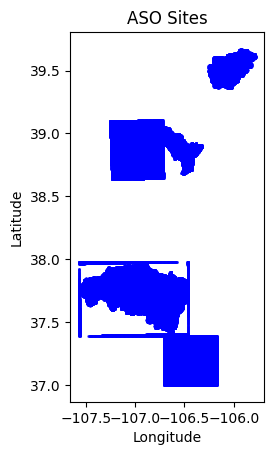

Grid GeoDataFrame length: 48240


<Figure size 1000x1000 with 0 Axes>

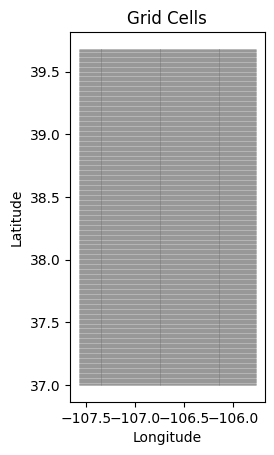

ASO GeoDataFrame after spatial join length: 305566
     cen_lat     cen_lon  swe_m                              cell_id  \
0  37.389854 -106.709326    0.0  SouthernRockies_300M_37.39_-106.709   
1  37.389854 -106.706626    0.0  SouthernRockies_300M_37.39_-106.707   
2  37.389854 -106.703926    0.0  SouthernRockies_300M_37.39_-106.704   
3  37.389854 -106.701226    0.0  SouthernRockies_300M_37.39_-106.701   
4  37.389854 -106.698526    0.0  SouthernRockies_300M_37.39_-106.699   

                      geometry  index_right  grid_cell_id  
0  POINT (-106.70933 37.38985)      23086.0       23086.0  
1  POINT (-106.70663 37.38985)      23086.0       23086.0  
2  POINT (-106.70393 37.38985)      23086.0       23086.0  
3  POINT (-106.70123 37.38985)      23086.0       23086.0  
4  POINT (-106.69853 37.38985)      23354.0       23354.0  
     cen_lat     cen_lon  grid_cell_id
0  37.389854 -106.709326       23086.0
1  37.389854 -106.706626       23086.0
2  37.389854 -106.703926       23086.0


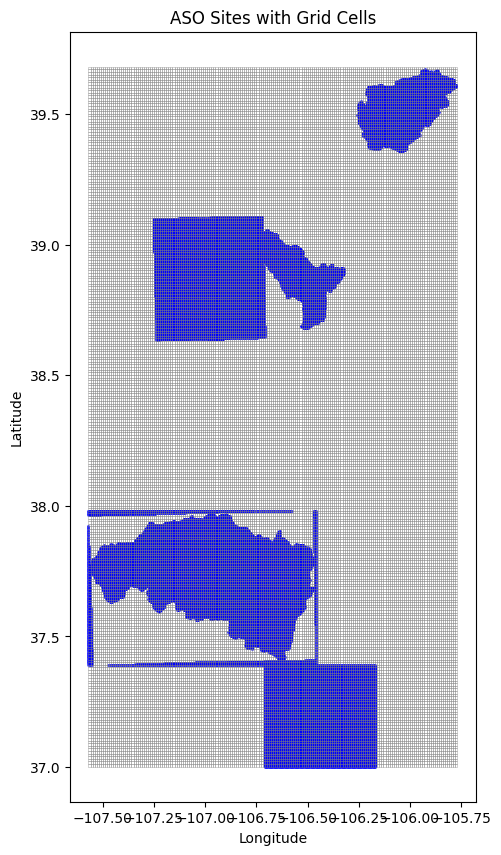

Grid GeoDataFrame with centroids:    centroid_lon  centroid_lat
0   -107.564471     37.006054
1   -107.564471     37.016054
2   -107.564471     37.026054
3   -107.564471     37.036054
4   -107.564471     37.046054
ASO GeoDataFrame after merging centroids length: 305566
     cen_lat     cen_lon  centroid_lon  centroid_lat
0  37.389854 -106.709326   -106.704471     37.386054
1  37.389854 -106.706626   -106.704471     37.386054
2  37.389854 -106.703926   -106.704471     37.386054
3  37.389854 -106.701226   -106.704471     37.386054
4  37.389854 -106.698526   -106.694471     37.386054
Number of unique centroid coordinates assigned: 10394


<Figure size 1000x1000 with 0 Axes>

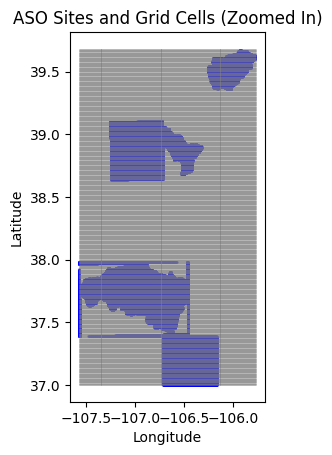

In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
import os
HOME = os.path.expanduser('~')

#function to calculate centroid coordinates
def calculate_centroid(geometry):
    centroid = geometry.centroid
    return centroid.x, centroid.y

#load ASO site data from Parquet files
parquet_folder = '300M_SWE_parquet'
region = 'SouthernRockies'
filepath = f"{HOME}/SWEMLv2.0/data/ASO/{region}/{parquet_folder}"
aso_sites = pd.read_parquet(filepath)

#ensure that aso_sites has columns 'cen_lat', 'cen_lon'
print(f"ASO sites DataFrame length: {len(aso_sites)}")
print(aso_sites.head())

#create a GeoDataFrame from ASO site data
geometry = [Point(xy) for xy in zip(aso_sites.cen_lon, aso_sites.cen_lat)]
crs = 'epsg:4326'  # Coordinate Reference System (CRS) for WGS84
aso_gdf = gpd.GeoDataFrame(aso_sites, crs=crs, geometry=geometry)
print(f"ASO GeoDataFrame length: {len(aso_gdf)}")

#plot the ASO sites to check if they are loaded correctly
plt.figure(figsize=(10, 10))
aso_gdf.plot(markersize=1, color='blue', alpha=0.5)
plt.title('ASO Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#define the grid cells to cover the area of ASO sites
minx, miny, maxx, maxy = aso_gdf.total_bounds
grid_cells = []
for lon in np.arange(minx, maxx, 0.01):
    for lat in np.arange(miny, maxy, 0.01):
        polygon = Polygon([
            (lon, lat),
            (lon + 0.01, lat),
            (lon + 0.01, lat + 0.01),
            (lon, lat + 0.01)
        ])
        grid_cells.append(polygon)

#create a GeoDataFrame for grid cells
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=crs)
grid_gdf['grid_cell_id'] = grid_gdf.index
print(f"Grid GeoDataFrame length: {len(grid_gdf)}")

#plot the grid cells to check if they are created correctly
plt.figure(figsize=(10, 10))
grid_gdf.boundary.plot(linewidth=0.5, color='gray', alpha=0.5)
plt.title('Grid Cells')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#spatially join ASO sites to grid cells
aso_gdf = gpd.sjoin(aso_gdf, grid_gdf, how='left', predicate='within')
print(f"ASO GeoDataFrame after spatial join length: {len(aso_gdf)}")
print(aso_gdf.head())

#ensure 'grid_cell_id' is correctly assigned
print(aso_gdf[['cen_lat', 'cen_lon', 'grid_cell_id']].head())

#plot the ASO sites with grid cell assignment
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.boundary.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.5)
aso_gdf.plot(ax=ax, markersize=1, color='blue', alpha=0.5)
plt.title('ASO Sites with Grid Cells')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#calculate centroids for each grid cell
grid_gdf['centroid'] = grid_gdf['geometry'].apply(calculate_centroid)
grid_gdf['centroid_lon'] = grid_gdf['centroid'].apply(lambda x: x[0])
grid_gdf['centroid_lat'] = grid_gdf['centroid'].apply(lambda x: x[1])
print(f"Grid GeoDataFrame with centroids: {grid_gdf[['centroid_lon', 'centroid_lat']].head()}")

#merge centroid coordinates to ASO sites based on grid_cell_id
aso_gdf = aso_gdf.merge(grid_gdf[['grid_cell_id', 'centroid_lon', 'centroid_lat']], on='grid_cell_id', how='left')
print(f"ASO GeoDataFrame after merging centroids length: {len(aso_gdf)}")
print(aso_gdf[['cen_lat', 'cen_lon', 'centroid_lon', 'centroid_lat']].head())

#check for unique assignments
unique_centroids = aso_gdf[['centroid_lon', 'centroid_lat']].drop_duplicates()
print(f"Number of unique centroid coordinates assigned: {len(unique_centroids)}")

#plot ASO sites and grid cells to visualize distribution
plt.figure(figsize=(10, 10))
grid_gdf.boundary.plot(linewidth=0.5, color='gray', alpha=0.5)
aso_gdf.plot(ax=plt.gca(), markersize=1, color='blue', alpha=0.5)
plt.title('ASO Sites and Grid Cells (Zoomed In)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
import boto3
import s3fs
import xarray as xr
import fsspec
import numpy as np
import time
import pandas as pd
import os
from scipy.optimize import fsolve  #need to install into venv
import os
import pandas as pd
import boto3
import s3fs
import zarr #need to install into venv

In [14]:
bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/forcing'
s3 = boto3.client('s3')
s3_filesystem = s3fs.S3FileSystem(anon=True)
files = s3_filesystem.ls(f'{bucket_url}') 

s3 = s3fs.S3FileSystem(f'{bucket_url}')        
zarr_store = s3fs.S3Map(files[2], s3=s3)
zarr = xr.open_zarr(store=zarr_store, consolidated=True)

In [15]:
zarr

<xarray.Dataset> Size: 27TB
Dimensions:   (time: 385704, y: 3840, x: 4608)
Coordinates:
  * time      (time) datetime64[ns] 3MB 1979-02-01 ... 2023-01-31T23:00:00
  * x         (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 31kB -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    RAINRATE  (time, y, x) float32 27TB ...
    crs       |S1 1B ...
Attributes:
    NWM_version_number:   v2.1
    model_configuration:  AORC
    model_output_type:    forcing

In [13]:
precip_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/forcing/precip.zarr'
# q2d_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/forcing/q2d.zarr'
# t2d_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/forcing/t2d.zarr'

# Connect to S3 filesystem
s3 = s3fs.S3FileSystem(anon=False)#,
                      # key=ACCESS['Access key ID'][0],
                       #secret=ACCESS['Secret access key'][0])

# Access Zarr stores
precip_store = zarr.open_consolidated(precip_url, s3=s3)
# q2d_store = zarr.open_consolidated(q2d_url, s3=s3)
# t2d_store = zarr.open_consolidated(t2d_url, s3=s3)

NoCredentialsError: Unable to locate credentials